In [3]:
from pandas_datareader import data, wb
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

# <font face="gotham" color="purple"> What is Autocorrelation? </font>

Recall that a classical linear regression model 
$$
Y_t = \beta_1 +\beta_2 X_t +u_t
$$

has an assumption
$$
E\left(u_{i} u_{j}\right)=0 \quad i \neq j
$$
i.e. disturbance terms are independent of each other. However, in many real situations, this assumption will not hold, especially in time series data. Many economic or financial time series data has a 'momentum', for instance, if we see a boost in consumer confidence in this month, it is more likely continue the momentum next month unless something unexpected happens. 

However if this assumption is violated, we have **autocorrelation** issue
$$
E\left(u_{i} u_{j}\right)\neq 0 \quad i \neq j
$$
There are many reasons why autocorrelation exists, but for now we don't care about the exact reason.

If we say a series is positively autocorrelated, it means correlation between successive values are positive, vice verse we call it negatively autorrelated. 

# <font face="gotham" color="purple"> AR And MA Processes </font>

If the disturbance term is generated by the process
$$
u_{t}=\rho u_{t-1}+\varepsilon_{t} \quad-1<\rho<1
$$
we call it a **First-Order Autoregression Process**, denoted $AR(1)$. And **innovation** $\varepsilon_{t}$ satisfies standard features of OLS disturbance term as below, and $\rho$ is coefficient of autocorrelation at lag $1$
$$
\begin{aligned}
E\left(\varepsilon_{t}\right) &=0 \\
\operatorname{Var}\left(\varepsilon_{t}\right) &=\sigma_{\varepsilon}^{2} \\
\operatorname{Cov}\left(\varepsilon_{t}, \varepsilon_{t+s}\right) &=0 \quad s \neq 0
\end{aligned}
$$
If $|\rho|<1$ we say that $AR(1)$ process is **stationary**, we'll get back to this topic in more details.

The main alternative is **moving average model** which is a weighted sum of current and previous values of $\varepsilon$'s, for instance $MA(2)$ is
$$
u_t = \lambda_0 \varepsilon_t+ \lambda_1 \varepsilon_{t-1}+ \lambda_2 \varepsilon_{t-2}
$$

# <font face="gotham" color="purple"> Autocorrelation Test </font>

The standard test for first order autocorrelation is **Durbin-Watson Test**, it is one of standard output of OLS estimation. It is calculated by the formula
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}}
$$

where $e_t$ is residual at time $t$. 

As an example, we can reproduce the OLS estimation of disposable income and house price in China. 

In [39]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'CN_Cities_house_price')
model = smf.ols(formula='house_price ~ salary', data=df)
results = model.fit()

from statsmodels.stats.stattools import durbin_watson as dw_test

dw_test(results.resid)

0.9255117521586905

Or we can write our own Durbin-Watson function to verify the results

In [38]:
def durbin_watson_test(series):
    nomin = np.sum((series[1:] - series.shift(1).dropna())**2)
    denom = np.sum(series**2)
    return nomin/denom
durbin_watson_test(results.resid)

0.9255117521586905

But how to interpret this number? Some mathematical manipulations of Durbin-Watson's statistic will bring some insight
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=2}^{T}\left(e^2_{t}-2e_te_{t-1}+e^2_{t-1}\right)}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=1}^Te_t^2}{\sum_{t=1}^Te_t^2}+\frac{\sum_{t=1}^Te_{t-1}^2}{\sum_{t=1}^Te_t^2}-2\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}
$$

If $T\rightarrow \infty$, the second term approaches $1$ infinitely and the third term $\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}$ equals $\rho$, because it is a simple OLS estimator of $\rho$. 

Therefore $dw \rightarrow 2-2\rho$ given $T\rightarrow \infty$.



If no autocorrelation, $\rho=0$, $dw$ should be $2$, if $\rho > .5$, i.e. strong positive autocorrelation, $dw$ will be close to $0$, or if $\rho>-.5$, i.e. strong negative autocorrelation, $dw$ will be close to $4$.

Because $dw$ statistic doesn't have critical value (due to some technical reason, critical value can't be calculated.)

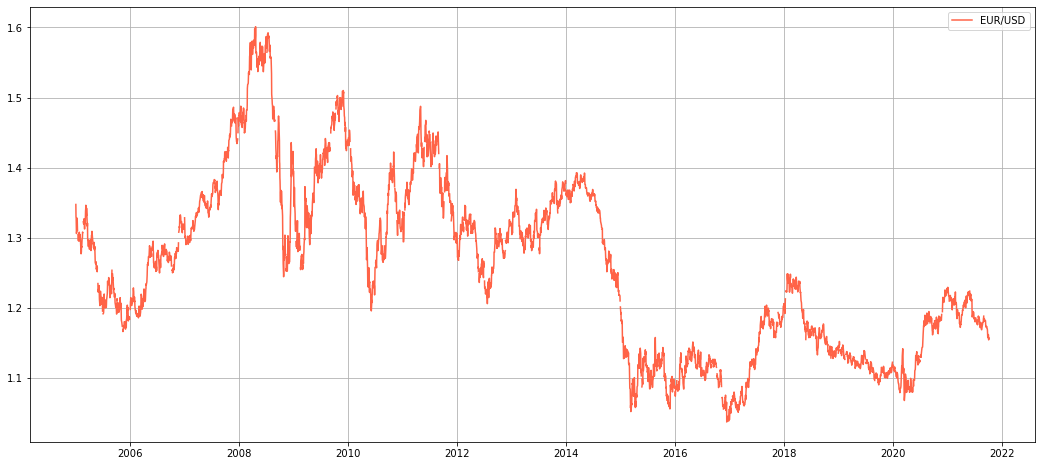

In [41]:
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today()
EURUSD = pdr.data.DataReader('DEXUSEU', 'fred', start, end)

fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(EURUSD, color = 'tomato', label = 'EUR/USD')
ax.legend()
ax.grid()
plt.show()

In [43]:
durbin_watson_test(EURUSD['DEXUSEU'])

3.206787081687621e-05